In [ ]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from numpy import argmax
from PIL import Image

import string
from pickle import load


from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, Embedding
#from keras.layers.concatenate import add
from keras.layers import concatenate as c
from keras.callbacks import ModelCheckpoint
from keras.layers import add

In [ ]:
# feature extraction from each photo
def feature_ext(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict() 
    for name in listdir(directory):
        file1 = directory + '/' + name
        img = load_img(file1, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        feature = model.predict(img, verbose=0)
        id = name.split('.')[0]
        features[id] = feature
        #print('>%s' % name)
    return features


directory = '/content/drive/MyDrive/archive/Images'
features = feature_ext(directory)
print('Extracted Features: %d' % len(features))


In [ ]:
dump(features, open('/content/drive/MyDrive/Image Captioning/features.pkl', 'wb'))

In [ ]:

def doc_loader(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
def load_desc(doc):
    map = dict()
    for line in doc.split('\n'):
        tok = line.split()
        if len(line) < 2:
            continue
        id, desc = tok[0], tok[1:]
        id = id.split('.')[0]
        desc = ' '.join(desc)
        if id not in map:
            map[id] = list()
        map[id].append(desc)
    return map

In [ ]:
#TEXT CLEANING

def clean(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, dlist in descriptions.items():
        for i in range(len(dlist)):
            desc = dlist[i]
            # tokenize
            desc = desc.split()
            #lower case
            desc = [word.lower() for word in desc]
            # remove punctuation
            desc = [w.translate(table) for w in desc]
            # remove hanging letters
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            dlist[i] =  ' '.join(desc)

In [ ]:
def to_vocab(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [ ]:
def save_desc(d, filename):
    lines = list()
    for key, desc_list in d.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
filename = '/content/drive/MyDrive/archive/captions.txt'
doc = doc_loader(filename)
d = load_desc(doc)
print('Loaded: %d ' % len(d))
clean(d)
vocabulary = to_vocab(d)
print('Vocabulary Size: %d' % len(vocabulary))
save_desc(d, '/content/drive/MyDrive/archive/descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8680


In [ ]:
def doc_loader(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
def load_set(filename):
    doc = doc_loader(filename)
    data = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        data.append(identifier)
    return set(data)



In [ ]:
def load_clean(filename, dataset):
    doc = doc_loader(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions



In [ ]:

def load_pfeatures(filename, dataset):
    all = load(open(filename, 'rb'))
    features = {i: all[i] for i in dataset}
    return features

In [ ]:
# load training dataset
filename = '/content/drive/MyDrive/Image-Caption-Generator-master/Image-Caption-Generator-master/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))


train_descriptions = load_clean('/content/drive/MyDrive/archive/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

train_features = load_pfeatures('/content/drive/MyDrive/archive/features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [ ]:

def lines(descriptions):
    desc = list()
    for key in descriptions.keys():
        [desc.append(d) for d in descriptions[key]]
    return desc


def tokenize(descriptions):
    l = lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(l)
    return tokenizer


def max_length(descriptions):
    l = lines(descriptions)
    return max(len(d.split()) for d in l)



In [ ]:

def sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    a, b, c = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            seq_in, out = seq[:i], seq[i]
            seq_in = pad_sequences([seq_in], maxlen=max_length)[0]
            out = to_categorical([out], num_classes=vocab_size)[0]
            a.append(photo)
            b.append(seq_in)
            c.append(out)
    return array(a), array(b), array(c)



In [ ]:
def cap_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    f1 = Dropout(0.5)(inputs1)
    f2 = Dense(256, activation='relu')(f1)
    i2 = Input(shape=(max_length,))
    s1 = Embedding(vocab_size, 256, mask_zero=True)(i2)
    s2 = Dropout(0.5)(s1)
    s3 = LSTM(256)(s2)
    decoder1 = add([f2, s3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, i2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


In [ ]:
def data_gen(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

In [ ]:
from pickle import dump
tokenizer = tokenize(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
dump(tokenizer, open('/content/drive/MyDrive/archive/tokenizer.pkl', 'wb'))

Vocabulary Size: 7507
Description Length: 33


In [ ]:
#define the model
model = cap_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    gen = data_gen(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    model.fit_generator(gen, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/Image Captioning/model_2' + str(i) + '.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 33, 256)      1921792     ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 4096)         0           ['input_8[0][0]']                
                                                                                            

<ipython-input-32-e2f3308dd4b2>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


6000/6000 [==============================] - 551s 92ms/step - loss: 3.1230


In [ ]:

def feature_ext(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature



In [ ]:

def wordid(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None



In [ ]:

def gen_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y = model.predict([photo,sequence], verbose=0)
        y = argmax(y)
        word = wordid(y, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [ ]:

tokenizer = load(open('/content/drive/MyDrive/archive/tokenizer.pkl', 'rb'))
print(type(tokenizer))

max_length = 33

model = load_model('/content/drive/MyDrive/archive/model_218.h5')


<class 'keras.preprocessing.text.Tokenizer'>


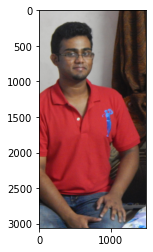

In [9]:
from matplotlib import pyplot as plt
from matplotlib import image as im
image = im.imread("/content/drive/MyDrive/archive/DSCN0304.JPG")
plt.imshow(image)
plt.show()
#using the below image as test image

In [ ]:

img = feature_ext('/content/drive/MyDrive/archive/DSCN0304.JPG')
description = gen_desc(model, tokenizer,img, max_length)


stopwords = ['startseq', 'endseq']

desc = [words for words in description.split() if words not in stopwords]
desc = ' '.join(desc)
print(desc)

young boy is wearing red shirt and holding his arm wide closed


**REFERENCES:**
* [1] Chetan Sagathiya, 2021, "Image Caption Generator", https://github.com/Chetan-Sagathiya/Image-Caption-Generator
* [2] AHMEDGAMAL12,2022, "Image_Caption_Generator",https://www.kaggle.com/code/ahmedgamal12/image-caption-generator
* [3] DAS KOUSHIK,2022, "ImageCaptioning", https://www.kaggle.com/code/daskoushik/imagecaptioning#Training-Model
* [4] Masum Ahmed EeSha, 2021, "Image Caption Generator with CNN & LSTM", https://www.youtube.com/watch?v=yWAhC95n5RM&t=7s